In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

%matplotlib inline

In [2]:
# create the path for the file

myPath = os.path.join('/Users', 'Bryan', 'Documents', 'Programming',
                      'time_series_forecasting_with_python',
                      'UDEMY_TSA_FINAL','Data')

print(myPath)

os.chdir(myPath)

/Users/Bryan/Documents/Programming/time_series_forecasting_with_python/UDEMY_TSA_FINAL/Data


In [3]:
df = pd.read_csv('Miles_Traveled.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [4]:
df.columns = ['Value']

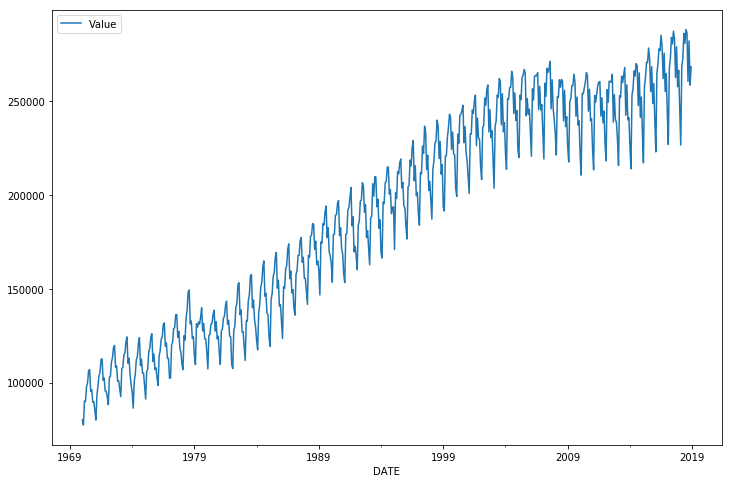

In [5]:
df.plot(figsize=(12,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
results = seasonal_decompose(df['Value'])

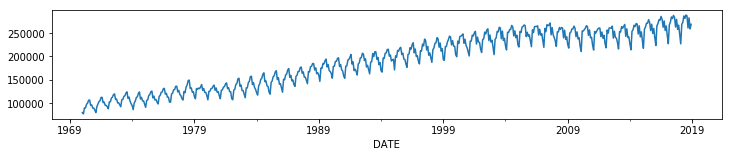

In [8]:
results.observed.plot(figsize=(12,2))

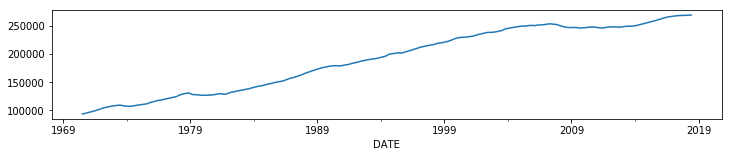

In [9]:
results.trend.plot(figsize=(12,2))

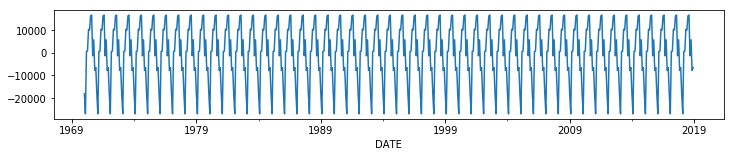

In [10]:
results.seasonal.plot(figsize=(12,2))

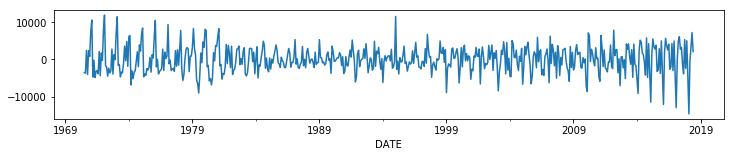

In [12]:
results.resid.plot(figsize=(12,2))

In [13]:
len(df)

588

In [14]:
train = df.iloc[:576]
test = df.iloc[576:]

In [15]:
len(test)

12

In [16]:
# need to scale data to 0 - 1 
from sklearn.preprocessing import MinMaxScaler

In [17]:
# find the max is the fit and dividing by max is transform
scaler = MinMaxScaler()

In [18]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
# use the preprocessing time series generator
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [21]:
scaled_test

array([[0.80158265],
       [0.71089704],
       [0.91013382],
       [0.92916661],
       [0.99438307],
       [0.969195  ],
       [1.00382085],
       [0.99649835],
       [0.8725685 ],
       [0.9753741 ],
       [0.86301637],
       [0.90981463]])

# Create the LSTM Model

In [23]:
n_input = 24
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [24]:
# import the keras components
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [25]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit_generator(generator, epochs=30)

Epoch 1/30
552/552 [==============================] - 22s 40ms/step - loss: 0.0166
Epoch 2/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0061
Epoch 3/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0065
Epoch 4/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0058
Epoch 5/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0055
Epoch 6/30
552/552 [==============================] - 21s 39ms/step - loss: 0.0052
Epoch 7/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0041
Epoch 8/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0030
Epoch 9/30
552/552 [==============================] - 21s 39ms/step - loss: 0.0021
Epoch 10/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0016
Epoch 11/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0016
Epoch 12/30
552/552 [==============================] - 21s 38ms/step - loss: 0.0013
E

In [30]:
loss_per_epoch = model.history.history['loss']

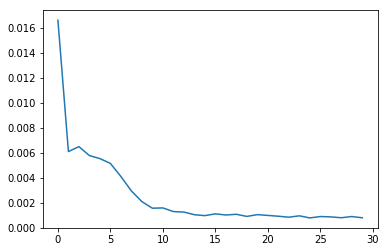

In [32]:
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [33]:
first_eval_batch = scaled_train[-12:]

In [34]:
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]

current_batch = first_eval_batch.reshape((1,n_input, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)


In [38]:
# inverse the transformations

true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
true_predictions

array([[252561.57470566],
       [236451.85221434],
       [270891.0120424 ],
       [279647.5381372 ],
       [288684.96287763],
       [289992.72047746],
       [296604.17279756],
       [292345.62822247],
       [277613.61274874],
       [285509.77726936],
       [269261.78238219],
       [274269.28992373]])

In [40]:
test['Predictions'] = true_predictions
test

/Users/Bryan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Value,Predictions
DATE,,
2018-01-01,245695.0,252561.574706
2018-02-01,226660.0,236451.852214
2018-03-01,268480.0,270891.012042
2018-04-01,272475.0,279647.538137
2018-05-01,286164.0,288684.962878
2018-06-01,280877.0,289992.720477
2018-07-01,288145.0,296604.172798
2018-08-01,286608.0,292345.628222
2018-09-01,260595.0,277613.612749


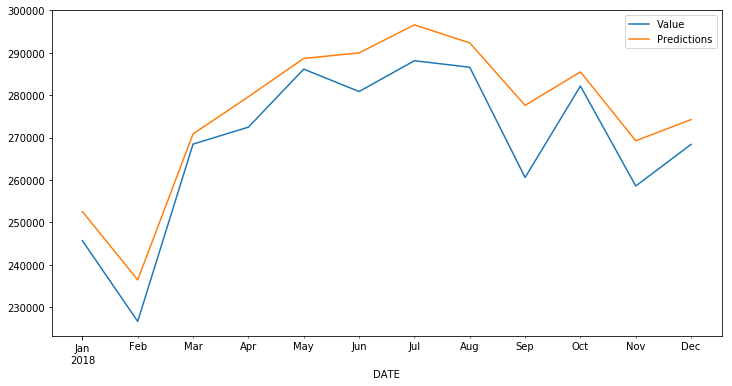

In [41]:
test.plot(figsize=(12,6))

In [42]:
model.save('RNNSolution.h5')